In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class TrajectoryDataset(Dataset):
    def __init__(self, dataframe, window_length=100):
        # Perform the custom transformation
        sliced_df = self.custom_transformation(dataframe.to_numpy(), window_length=window_length)
        self.data = torch.tensor(sliced_df, dtype=torch.float32)

    def __len__(self):
        # Return the number of trajectories
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Get the trajectory at the given index
        return self.data[idx]

    def custom_transformation(self, dataframe_array, window_length):
        num_rows, num_cols = dataframe_array.shape
        window_length += 1  # get one more column as targets

        # Preallocate memory for the slices
        sliced_data = np.lib.stride_tricks.sliding_window_view(dataframe_array, window_shape=(window_length,), axis=1)

        # Reshape into a flat 2D array for DataFrame-like output
        sliced_data = sliced_data.reshape(-1, window_length)

        return sliced_data

In [3]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
dataset_path = "./dataset/"

# Get the relative path of a file in the current working directory
train_path = os.path.join(dataset_path + "train.csv")
val_path = os.path.join(dataset_path + "val.csv")
test_path = os.path.join(dataset_path + "test.csv")

train_df = pd.read_csv(train_path, header=0).drop("ids", axis=1)
val_df = pd.read_csv(val_path, header=0).drop("ids", axis=1)
test_df = pd.read_csv(test_path, header=0).drop("ids", axis=1)

# print the training data shape
print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (963, 7560)
Validation data shape: (963, 1500)
Testing data shape: (963, 1500)


## Training loop

In [5]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [6]:
# Hyperparameters
window_length = 100
batch_size = 64
input_size = 1
hidden_size = 64  # Increased hidden size - 128
num_layers = 2  # Increased number of layers - 3
output_size = 1
learning_rate = 0.001
num_epochs = 10  # Increased number of epochs
dropout = 0.2  # Added dropout - 0.3
patience = 5  # Early stopping patience
weight_decay = 1e-5  # L2 regularization

In [ ]:
# Prepare dataset and dataloader
train_dataset = TrajectoryDataset(dataframe=train_df, window_length=window_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3, factor=0.5)

# Early stopping variables
best_train_loss = float("inf")
epochs_no_improve = 0
early_stop = False

print(f"Initial best_train_loss: {best_train_loss}")
print(f"Epochs_no_improve: {epochs_no_improve}")
print(f"Patience threshold set to: {patience}\n")

Initial best_train_loss: inf
Epochs_no_improve: 0
Patience threshold set to: 5



In [ ]:
# Training loop with tqdm for progress tracking
for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    if early_stop:
        print("Early stopping triggered")
        break

    model.train()
    running_loss = 0.0

    for batch_idx, data in tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch + 1}", unit="batch", leave=False):
        inputs = data[:, :-1].unsqueeze(2).to(device)
        targets = data[:, -1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:}")
    scheduler.step(avg_loss)

    # Early stopping check
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
        print(f"Improvement observed. New best_train_loss: {best_train_loss:}. Model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement. epochs_no_improve: {epochs_no_improve}/{patience}")
        if epochs_no_improve >= patience:
            early_stop = True

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

Epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]
Epoch 1: 0batch [00:00, ?batch/s]
Epoch 1: 1batch [00:00,  3.02batch/s]
Epoch 1: 55batch [00:00, 164.74batch/s]
Epoch 1: 111batch [00:00, 282.06batch/s]
Epoch 1: 167batch [00:00, 363.58batch/s]
Epoch 1: 223batch [00:00, 420.76batch/s]
Epoch 1: 279batch [00:00, 460.69batch/s]
Epoch 1: 335batch [00:00, 488.65batch/s]
Epoch 1: 391batch [00:01, 508.17batch/s]
Epoch 1: 447batch [00:01, 521.60batch/s]
Epoch 1: 503batch [00:01, 531.22batch/s]
Epoch 1: 559batch [00:01, 537.60batch/s]
Epoch 1: 615batch [00:01, 542.10batch/s]
Epoch 1: 671batch [00:01, 545.09batch/s]
Epoch 1: 727batch [00:01, 547.03batch/s]
Epoch 1: 783batch [00:01, 548.15batch/s]
Epoch 1: 839batch [00:01, 549.32batch/s]
Epoch 1: 895batch [00:01, 550.53batch/s]
Epoch 1: 951batch [00:02, 551.31batch/s]
Epoch 1: 1007batch [00:02, 551.87batch/s]
Epoch 1: 1063batch [00:02, 552.76batch/s]
Epoch 1: 1119batch [00:02, 553.82batch/s]
Epoch 1: 1175batch [00:02, 554.50batch/s]
Epoch 1: 1231b

Epoch [1/10], Loss: 0.0005414275685416012
Improvement observed. New best_train_loss: 0.0005414275685416012. Model saved.



Epoch 2: 0batch [00:00, ?batch/s]
Epoch 2: 9batch [00:00, 88.91batch/s]
Epoch 2: 66batch [00:00, 367.93batch/s]
Epoch 2: 125batch [00:00, 468.04batch/s]
Epoch 2: 185batch [00:00, 518.41batch/s]
Epoch 2: 245batch [00:00, 545.95batch/s]
Epoch 2: 305batch [00:00, 562.16batch/s]
Epoch 2: 365batch [00:00, 572.73batch/s]
Epoch 2: 425batch [00:00, 580.19batch/s]
Epoch 2: 485batch [00:00, 584.68batch/s]
Epoch 2: 545batch [00:01, 587.03batch/s]
Epoch 2: 605batch [00:01, 589.33batch/s]
Epoch 2: 665batch [00:01, 591.33batch/s]
Epoch 2: 725batch [00:01, 593.00batch/s]
Epoch 2: 785batch [00:01, 593.58batch/s]
Epoch 2: 845batch [00:01, 594.44batch/s]
Epoch 2: 905batch [00:01, 594.88batch/s]
Epoch 2: 965batch [00:01, 595.47batch/s]
Epoch 2: 1025batch [00:01, 595.81batch/s]
Epoch 2: 1085batch [00:01, 595.51batch/s]
Epoch 2: 1145batch [00:02, 595.87batch/s]
Epoch 2: 1205batch [00:02, 596.04batch/s]
Epoch 2: 1265batch [00:02, 595.76batch/s]
Epoch 2: 1325batch [00:02, 595.84batch/s]
Epoch 2: 1385batch [

Epoch [2/10], Loss: 0.0005403132893012917
Improvement observed. New best_train_loss: 0.0005403132893012917. Model saved.



Epoch 3: 0batch [00:00, ?batch/s]
Epoch 3: 9batch [00:00, 88.71batch/s]
Epoch 3: 65batch [00:00, 363.73batch/s]
Epoch 3: 124batch [00:00, 466.33batch/s]
Epoch 3: 184batch [00:00, 516.77batch/s]
Epoch 3: 244batch [00:00, 544.94batch/s]
Epoch 3: 304batch [00:00, 561.15batch/s]
Epoch 3: 364batch [00:00, 572.72batch/s]
Epoch 3: 424batch [00:00, 580.15batch/s]
Epoch 3: 484batch [00:00, 585.29batch/s]
Epoch 3: 544batch [00:01, 589.17batch/s]
Epoch 3: 604batch [00:01, 591.71batch/s]
Epoch 3: 664batch [00:01, 593.65batch/s]
Epoch 3: 724batch [00:01, 594.43batch/s]
Epoch 3: 784batch [00:01, 595.24batch/s]
Epoch 3: 844batch [00:01, 595.84batch/s]
Epoch 3: 904batch [00:01, 596.42batch/s]
Epoch 3: 964batch [00:01, 596.77batch/s]
Epoch 3: 1024batch [00:01, 596.99batch/s]
Epoch 3: 1084batch [00:01, 596.92batch/s]
Epoch 3: 1144batch [00:02, 596.92batch/s]
Epoch 3: 1204batch [00:02, 597.03batch/s]
Epoch 3: 1264batch [00:02, 596.82batch/s]
Epoch 3: 1324batch [00:02, 596.69batch/s]
Epoch 3: 1384batch [

Epoch [3/10], Loss: 0.0005403001842530157
Improvement observed. New best_train_loss: 0.0005403001842530157. Model saved.



Epoch 4: 0batch [00:00, ?batch/s]
Epoch 4: 6batch [00:00, 59.19batch/s]
Epoch 4: 62batch [00:00, 351.84batch/s]
Epoch 4: 120batch [00:00, 455.09batch/s]
Epoch 4: 180batch [00:00, 509.04batch/s]
Epoch 4: 240batch [00:00, 538.65batch/s]
Epoch 4: 300batch [00:00, 556.63batch/s]
Epoch 4: 360batch [00:00, 568.08batch/s]
Epoch 4: 420batch [00:00, 575.47batch/s]
Epoch 4: 480batch [00:00, 580.33batch/s]
Epoch 4: 540batch [00:01, 583.95batch/s]
Epoch 4: 600batch [00:01, 586.38batch/s]
Epoch 4: 660batch [00:01, 588.34batch/s]
Epoch 4: 720batch [00:01, 589.59batch/s]
Epoch 4: 780batch [00:01, 590.29batch/s]
Epoch 4: 840batch [00:01, 590.80batch/s]
Epoch 4: 900batch [00:01, 591.17batch/s]
Epoch 4: 960batch [00:01, 591.49batch/s]
Epoch 4: 1020batch [00:01, 590.62batch/s]
Epoch 4: 1080batch [00:01, 591.12batch/s]
Epoch 4: 1140batch [00:02, 591.39batch/s]
Epoch 4: 1200batch [00:02, 591.53batch/s]
Epoch 4: 1260batch [00:02, 591.80batch/s]
Epoch 4: 1320batch [00:02, 591.76batch/s]
Epoch 4: 1380batch [

Epoch [4/10], Loss: 0.0005402028381959707
Improvement observed. New best_train_loss: 0.0005402028381959707. Model saved.



Epoch 5: 0batch [00:00, ?batch/s]
Epoch 5: 9batch [00:00, 89.10batch/s]
Epoch 5: 66batch [00:00, 368.89batch/s]
Epoch 5: 125batch [00:00, 468.30batch/s]
Epoch 5: 185batch [00:00, 516.83batch/s]
Epoch 5: 245batch [00:00, 544.45batch/s]
Epoch 5: 305batch [00:00, 561.07batch/s]
Epoch 5: 365batch [00:00, 571.64batch/s]
Epoch 5: 425batch [00:00, 578.40batch/s]
Epoch 5: 485batch [00:00, 582.86batch/s]
Epoch 5: 545batch [00:01, 586.16batch/s]
Epoch 5: 605batch [00:01, 588.25batch/s]
Epoch 5: 665batch [00:01, 589.25batch/s]
Epoch 5: 725batch [00:01, 590.50batch/s]
Epoch 5: 785batch [00:01, 591.63batch/s]
Epoch 5: 845batch [00:01, 590.28batch/s]
Epoch 5: 905batch [00:01, 591.38batch/s]
Epoch 5: 965batch [00:01, 592.55batch/s]
Epoch 5: 1025batch [00:01, 593.37batch/s]
Epoch 5: 1085batch [00:01, 594.18batch/s]
Epoch 5: 1145batch [00:02, 594.55batch/s]
Epoch 5: 1205batch [00:02, 593.82batch/s]
Epoch 5: 1265batch [00:02, 594.00batch/s]
Epoch 5: 1325batch [00:02, 594.53batch/s]
Epoch 5: 1385batch [

Epoch [5/10], Loss: 0.000540061434666295
Improvement observed. New best_train_loss: 0.000540061434666295. Model saved.



Epoch 6: 0batch [00:00, ?batch/s]
Epoch 6: 9batch [00:00, 88.96batch/s]
Epoch 6: 68batch [00:00, 380.54batch/s]
Epoch 6: 127batch [00:00, 475.67batch/s]
Epoch 6: 187batch [00:00, 522.81batch/s]
Epoch 6: 247batch [00:00, 548.64batch/s]
Epoch 6: 307batch [00:00, 564.37batch/s]
Epoch 6: 367batch [00:00, 574.31batch/s]
Epoch 6: 427batch [00:00, 581.19batch/s]
Epoch 6: 487batch [00:00, 585.93batch/s]
Epoch 6: 547batch [00:01, 589.46batch/s]
Epoch 6: 607batch [00:01, 591.51batch/s]
Epoch 6: 667batch [00:01, 592.61batch/s]
Epoch 6: 727batch [00:01, 593.36batch/s]
Epoch 6: 787batch [00:01, 594.10batch/s]
Epoch 6: 847batch [00:01, 594.57batch/s]
Epoch 6: 907batch [00:01, 594.69batch/s]
Epoch 6: 967batch [00:01, 593.83batch/s]
Epoch 6: 1027batch [00:01, 593.31batch/s]
Epoch 6: 1087batch [00:01, 593.19batch/s]
Epoch 6: 1147batch [00:02, 592.99batch/s]
Epoch 6: 1207batch [00:02, 593.14batch/s]
Epoch 6: 1267batch [00:02, 583.31batch/s]
Epoch 6: 1327batch [00:02, 586.41batch/s]
Epoch 6: 1387batch [

Epoch [6/10], Loss: 0.0005401469628826481
No improvement. epochs_no_improve: 1/5



Epoch 7: 0batch [00:00, ?batch/s]
Epoch 7: 11batch [00:00, 109.32batch/s]
Epoch 7: 66batch [00:00, 366.02batch/s]
Epoch 7: 124batch [00:00, 460.92batch/s]
Epoch 7: 182batch [00:00, 507.58batch/s]
Epoch 7: 241batch [00:00, 533.92batch/s]
Epoch 7: 299batch [00:00, 549.08batch/s]
Epoch 7: 357batch [00:00, 558.62batch/s]
Epoch 7: 415batch [00:00, 564.39batch/s]
Epoch 7: 473batch [00:00, 569.21batch/s]
Epoch 7: 531batch [00:01, 572.05batch/s]
Epoch 7: 589batch [00:01, 574.25batch/s]
Epoch 7: 647batch [00:01, 575.35batch/s]
Epoch 7: 705batch [00:01, 576.35batch/s]
Epoch 7: 763batch [00:01, 576.49batch/s]
Epoch 7: 821batch [00:01, 577.10batch/s]
Epoch 7: 880batch [00:01, 578.00batch/s]
Epoch 7: 938batch [00:01, 578.43batch/s]
Epoch 7: 996batch [00:01, 578.75batch/s]
Epoch 7: 1054batch [00:01, 578.91batch/s]
Epoch 7: 1112batch [00:02, 578.72batch/s]
Epoch 7: 1170batch [00:02, 579.00batch/s]
Epoch 7: 1228batch [00:02, 578.77batch/s]
Epoch 7: 1286batch [00:02, 578.79batch/s]
Epoch 7: 1344batch 

Epoch [7/10], Loss: 0.0005403243604456184
No improvement. epochs_no_improve: 2/5



Epoch 8: 0batch [00:00, ?batch/s]
Epoch 8: 7batch [00:00, 69.61batch/s]
Epoch 8: 62batch [00:00, 350.39batch/s]
Epoch 8: 121batch [00:00, 459.29batch/s]
Epoch 8: 181batch [00:00, 512.40batch/s]
Epoch 8: 241batch [00:00, 542.22batch/s]
Epoch 8: 301batch [00:00, 560.15batch/s]
Epoch 8: 361batch [00:00, 571.25batch/s]
Epoch 8: 421batch [00:00, 578.88batch/s]
Epoch 8: 481batch [00:00, 584.05batch/s]
Epoch 8: 541batch [00:01, 587.56batch/s]
Epoch 8: 601batch [00:01, 589.72batch/s]
Epoch 8: 661batch [00:01, 591.30batch/s]
Epoch 8: 721batch [00:01, 592.52batch/s]
Epoch 8: 781batch [00:01, 593.30batch/s]
Epoch 8: 841batch [00:01, 593.57batch/s]
Epoch 8: 901batch [00:01, 594.22batch/s]
Epoch 8: 961batch [00:01, 594.89batch/s]
Epoch 8: 1021batch [00:01, 595.50batch/s]
Epoch 8: 1081batch [00:01, 595.31batch/s]
Epoch 8: 1141batch [00:02, 582.30batch/s]
Epoch 8: 1201batch [00:02, 584.95batch/s]
Epoch 8: 1260batch [00:02, 586.38batch/s]
Epoch 8: 1319batch [00:02, 587.19batch/s]
Epoch 8: 1378batch [

Epoch [8/10], Loss: 0.0005403178328508718
No improvement. epochs_no_improve: 3/5



Epoch 9: 0batch [00:00, ?batch/s]
Epoch 9: 7batch [00:00, 69.86batch/s]
Epoch 9: 64batch [00:00, 360.36batch/s]
Epoch 9: 123batch [00:00, 461.26batch/s]
Epoch 9: 182batch [00:00, 511.27batch/s]
Epoch 9: 241batch [00:00, 539.43batch/s]
Epoch 9: 301batch [00:00, 556.87batch/s]
Epoch 9: 361batch [00:00, 567.75batch/s]
Epoch 9: 421batch [00:00, 574.89batch/s]
Epoch 9: 480batch [00:00, 579.25batch/s]
Epoch 9: 540batch [00:01, 582.32batch/s]
Epoch 9: 600batch [00:01, 585.76batch/s]
Epoch 9: 660batch [00:01, 587.91batch/s]
Epoch 9: 720batch [00:01, 590.07batch/s]
Epoch 9: 780batch [00:01, 591.08batch/s]
Epoch 9: 840batch [00:01, 591.65batch/s]
Epoch 9: 900batch [00:01, 592.05batch/s]
Epoch 9: 960batch [00:01, 592.36batch/s]
Epoch 9: 1020batch [00:01, 592.99batch/s]
Epoch 9: 1080batch [00:01, 592.91batch/s]
Epoch 9: 1140batch [00:02, 593.04batch/s]
Epoch 9: 1200batch [00:02, 593.15batch/s]
Epoch 9: 1260batch [00:02, 593.70batch/s]
Epoch 9: 1320batch [00:02, 594.04batch/s]
Epoch 9: 1380batch [

Epoch [9/10], Loss: 0.0005404728263307245
No improvement. epochs_no_improve: 4/5



Epoch 10: 0batch [00:00, ?batch/s]
Epoch 10: 11batch [00:00, 108.36batch/s]
Epoch 10: 66batch [00:00, 363.49batch/s]
Epoch 10: 124batch [00:00, 460.59batch/s]
Epoch 10: 183batch [00:00, 507.97batch/s]
Epoch 10: 242batch [00:00, 534.26batch/s]
Epoch 10: 301batch [00:00, 549.97batch/s]
Epoch 10: 359batch [00:00, 559.55batch/s]
Epoch 10: 418batch [00:00, 566.25batch/s]
Epoch 10: 477batch [00:00, 570.76batch/s]
Epoch 10: 536batch [00:01, 573.76batch/s]
Epoch 10: 594batch [00:01, 572.84batch/s]
Epoch 10: 652batch [00:01, 574.96batch/s]
Epoch 10: 711batch [00:01, 576.71batch/s]
Epoch 10: 769batch [00:01, 577.00batch/s]
Epoch 10: 827batch [00:01, 577.55batch/s]
Epoch 10: 885batch [00:01, 578.05batch/s]
Epoch 10: 943batch [00:01, 578.33batch/s]
Epoch 10: 1001batch [00:01, 578.52batch/s]
Epoch 10: 1059batch [00:01, 578.94batch/s]
Epoch 10: 1117batch [00:02, 579.08batch/s]
Epoch 10: 1175batch [00:02, 578.37batch/s]
Epoch 10: 1233batch [00:02, 578.77batch/s]
Epoch 10: 1291batch [00:02, 579.08bat

Epoch [10/10], Loss: 0.0005328772462499204
Improvement observed. New best_train_loss: 0.0005328772462499204. Model saved.


<All keys matched successfully>

## Evaluation Loop

In [9]:
# Autoregressive prediction function
def autoregressive_predict(model, input_matrix, prediction_length):
    """
    Perform autoregressive prediction using the learned model.

    Args:
    - model: The trained PyTorch model.
    - input_matrix: A matrix of initial time steps (e.g., shape (963, window_length)).
    - prediction_length: The length of the future trajectory to predict.

    Returns:
    - output_matrix: A tensor of the predicted future trajectory of the same length as `prediction_length`.
    """
    model.eval()  # Set model to evaluation mode
    input_matrix = input_matrix.to(next(model.parameters()).device)  # Move to model's device
    output_matrix = torch.empty(input_matrix.shape[0], 0).to(next(model.parameters()).device)  # Initialize on the model's device
    current_input = input_matrix

    with torch.no_grad():  # No need to calculate gradients for prediction
        for _ in range(prediction_length):
            # Predict the next time step
            next_pred = model(current_input.unsqueeze(2))

            # Concatenating the new column along dimension 1 (columns)
            output_matrix = torch.cat((output_matrix, next_pred), dim=1)

            # Use the predicted value as part of the next input
            current_input = torch.cat((current_input[:, 1:], next_pred), dim=1)

    return output_matrix

In [10]:
# Prepare train, validation and test data tensors
train_set = torch.tensor(train_df.values[:, :].astype(np.float32), dtype=torch.float32).to(device)  # Move to the appropriate device
val_set = torch.tensor(val_df.values[:, :].astype(np.float32), dtype=torch.float32).to(device)  # Move to the appropriate device
test_set = torch.tensor(val_df.values[:, :].astype(np.float32), dtype=torch.float32).to(device)  # Move to the appropriate device

In [11]:
# Generate predictions for validation set
initial_input = train_set[:, -window_length:]  # use the last window of training set as initial input
val_predictions_tensor = autoregressive_predict(model, initial_input, val_set.shape[1])
print(f"Validation Predictions Tensor Shape: {val_predictions_tensor.shape}")

# Calculate MSE between predicted trajectories and actual validation trajectories for validation
mse_loss = nn.MSELoss()  # Calculate MSE for validation set
mse = mse_loss(val_predictions_tensor, val_set)  # Compute MSE
print(f"Autoregressive Validation MSE: {mse.item():.4f}")

Validation Predictions Tensor Shape: torch.Size([963, 1500])
Autoregressive Validation MSE: 0.0022


## Plot it out to see what is like

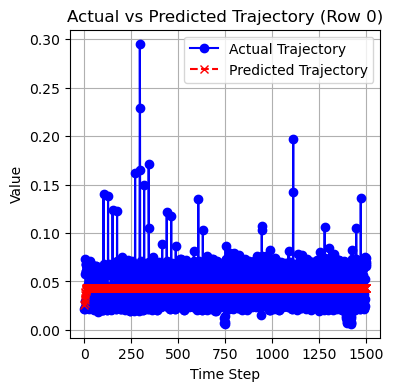

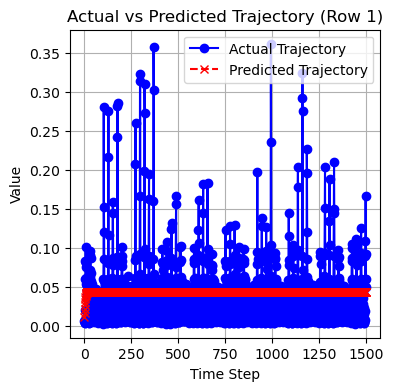

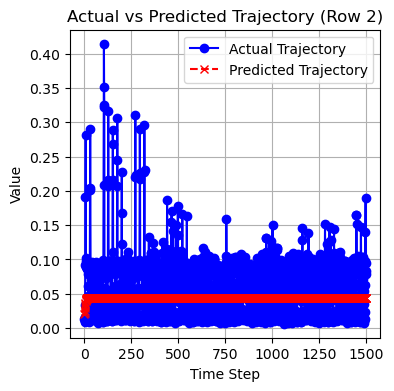

In [12]:
for row_idx in range(3):
    initial_input = val_set[row_idx, :window_length].unsqueeze(0)

    # Use the previously generated prediction for the validation set
    predicted_trajectory = val_predictions_tensor[row_idx].cpu().numpy()

    # Get the actual trajectory for comparison
    actual_trajectory = val_set[row_idx].cpu().numpy()

    # Plot the actual vs predicted trajectory
    plt.figure(figsize=(4, 4))
    plt.plot(range(len(actual_trajectory)), actual_trajectory, label="Actual Trajectory", color="blue", marker="o")
    plt.plot(range(len(predicted_trajectory)), predicted_trajectory, label="Predicted Trajectory", color="red", linestyle="--", marker="x")
    plt.title(f"Actual vs Predicted Trajectory (Row {row_idx})")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"trajectory_{row_idx}.png", dpi=200)
    plt.show()

## Generate the submission csv

In [13]:
# Generate predictions for the test dataset
initial_input = val_predictions_tensor[:, -window_length:]
test_predictions_tensor = autoregressive_predict(model, initial_input, test_set.shape[1])

print(f"Test Predictions Tensor Shape: {test_predictions_tensor.shape}")

Test Predictions Tensor Shape: torch.Size([963, 1500])


In [14]:
def generate_submissions_v4(pred_val_tensor, pred_test_tensor, original_val_path, original_test_path):
    # Read the original validation and testing datasets
    original_val_df = pd.read_csv(original_val_path)
    original_test_df = pd.read_csv(original_test_path)

    # Ensure the shape of pred_val_tensor and pred_test_tensor is correct
    assert pred_val_tensor.shape[0] * pred_val_tensor.shape[1] == original_val_df.shape[0] * (original_val_df.shape[1] - 1)
    assert pred_test_tensor.shape[0] * pred_test_tensor.shape[1] == original_test_df.shape[0] * (original_test_df.shape[1] - 1)

    # Create empty lists to store ids and values
    ids = []
    values = []

    # Process validation set
    for col_idx, col in enumerate(original_val_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_val_df[col]):
            ids.append(str(f"{col}_traffic_val_{row_idx}"))
            values.append(float(pred_val_tensor[row_idx, col_idx]))

    # Process testing set
    for col_idx, col in enumerate(original_test_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_test_df[col]):
            ids.append(str(f"{col}_traffic_test_{row_idx}"))
            values.append(float(pred_test_tensor[row_idx, col_idx]))

    # Create the submissions dataframe
    submissions_df = pd.DataFrame({"ids": ids, "value": values})

    # Impute any null values
    submissions_df.fillna(100, inplace=True)

    # Assert the shape of the dataframe
    assert submissions_df.shape[1] == 2
    assert submissions_df.shape[0] == (original_val_df.shape[0] * (original_val_df.shape[1] - 1)) + (
        original_test_df.shape[0] * (original_test_df.shape[1] - 1)
    )
    assert "ids" in submissions_df.columns
    assert "value" in submissions_df.columns

    # Save to CSV
    submissions_df.to_csv("submissions_v3.csv", index=False)


# Call the function
generate_submissions_v4(val_predictions_tensor, test_predictions_tensor, val_path, test_path)